# MRtrix: Part 3 
## Registration and Streamline Fitting


This notebook is the third in a series on Diffusion Analysis using MRtrix and builds upon the data generated in **MRtrix: Part 2 - Constrained Spherical Deconvolution and Tissue estimation**. The data necessary for this example will be downloaded from OSF. This notebook will focus on coregistration of the diffusion and anatomical images and generation of streamlines, building on the concepts introduced earlier.


####
Author: Monika Doerig

Citation:

__Andy's Brain Book:__

- This MRtrix example is based on the [Diffusion Analysis with MRtrix](https://andysbrainbook.readthedocs.io/en/latest/MRtrix/MRtrix_Introduction.html#) chapter from Andy’s Brain Book (Jahn, 2022. [doi:10.5281/zenodo.5879293](https://zenodo.org/records/5879294))

__Original Data from OpenNeuro:__
- Hannelore Aerts and Daniele Marinazzo (2018). BTC_preop. [OpenNeuro Dataset ds001226](https://openneuro.org/datasets/ds001226/versions/00001)

__Diffusion Data from the Previous Notebook (Available on OSF):__
- Dörig, M. (2024, November 19). Diffusion MRI Analysis with MRtrix: An Interactive Three-Part Series on Neurodesk. Retrieved from [OSF](https://osf.io/y2dq4/)

__MRtrix3:__ 
- Tournier, J.-D.; Smith, R. E.; Raffelt, D.; Tabbara, R.; Dhollander, T.; Pietsch, M.; Christiaens, D.; Jeurissen, B.; Yeh, C.-H. & Connelly, A. MRtrix3: A fast, flexible and open software framework for medical image processing and visualisation. NeuroImage, 2019, 202, 116137. https://doi.org/10.1016/j.neuroimage.2019.116137
- For more details: https://www.mrtrix.org/

__Fury - Free Unified Rendering in Python:__
- Eleftherios Garyfallidis, Serge Koudoro, Javier Guaje, Marc-Alexandre Côté, Soham Biswas, David Reagan, Nasim Anousheh, Filipi Silva, Geoffrey Fox, and Fury Contributors. "FURY: advanced scientific visualization." Journal of Open Source Software 6, no. 64 (2021): 3384. https://doi.org/10.21105/joss.03384
- https://fury.gl/latest/index.html

### Output CPU information

In [2]:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


### Import Python Libraries

In [3]:
%%capture
! pip install nibabel matplotlib fury numpy

In [4]:
import os
import subprocess
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tempfile
from ipyniivue import NiiVue, SliceType
from IPython.display import display, Markdown
import ipywidgets as widgets
from fury import colormap
import random

### Load modules

In [5]:
import module
await module.load('mrtrix3/3.0.4')
await module.load('fsl/6.0.7.4')
await module.list()

['mrtrix3/3.0.4', 'fsl/6.0.7.4']

## Downloading the data from MRtrix Part 2

In [6]:
! osf -p y2dq4 fetch fod/5tt_nocoreg.mif MRtrix_fod/5tt_nocoreg.mif
! osf -p y2dq4 fetch fod/csffod_norm.mif MRtrix_fod/csffod_norm.mif
! osf -p y2dq4 fetch fod/gmfod_norm.mif MRtrix_fod/gmfod_norm.mif
! osf -p y2dq4 fetch fod/wmfod_norm.mif MRtrix_fod/wmfod_norm.mif
! osf -p y2dq4 fetch fod/sub-02_den_preproc_unbiased.mif MRtrix_fod/sub-02_den_preproc_unbiased.mif

100%|███████████████████████████████████| 75.4M/75.4M [00:00<00:00, 151Mbytes/s]
100%|██████████████████████████████████| 2.22M/2.22M [00:00<00:00, 49.8Mbytes/s]
100%|██████████████████████████████████| 2.22M/2.22M [00:00<00:00, 54.0Mbytes/s]
100%|███████████████████████████████████| 99.5M/99.5M [00:00<00:00, 201Mbytes/s]
100%|█████████████████████████████████████| 226M/226M [00:01<00:00, 161Mbytes/s]


Try typing one of the commands from the library, such as ```mrconvert```. If MRtrix has been installed correctly, you should see the help page printed by default when no arguments are passed to the command:

In [7]:
!mrconvert | head -n 18

MRtrix 3.0.4                        mrconvert                        Mar 20 2024

     mrconvert: part of the MRtrix3 package

SYNOPSIS

     Perform conversion between different file types and optionally extract a
     subset of the input image

USAGE

     mrconvert [ options ] input output

        input        the input image.

        output       the output image.




## Coregistering the Diffusion and Anatomical Images
Our next step is to coregister the anatomical and diffusion-weighted images. This ensures that the boundaries of the tissue types are aligned with the boundaries of the diffusion-weighted images; even small differences in the location of the two scans can throw off the tractography results.

We will first use the commands ```dwiextract``` and ```mrmath``` to average together the B0 images from the diffusion data. These are the images that look most like T2-weighted functional scans, since a diffusion gradient wasn’t applied during their acquisition - in other words, they were acquired with a b-value of zero. To see how this works, type the following command:

In [8]:
! dwiextract ./MRtrix_fod/sub-02_den_preproc_unbiased.mif - -bzero | mrmath - mean ./MRtrix_fod/mean_b0.mif -axis 3

dwiextract: [100%] extracting volumes[0K
mrmath: [100%] preloading data for "/tmp/mrtrix-tmp-Td4RG3.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K


##### 
There are two parts to this command, separated by a pipe (”|”). The left half of the command, ```dwiextract```, takes the preprocessed diffusion-weighted image as an input, and the -bzero option extracts the B0 images; the solitary - argument indicates that the output should be used as input for the second part of the command, to the right of the pipe. ```mrmath``` then takes these output B0 images and computes the mean along the 3rd axis, or the time dimension. In other words, if we start with an index of 0, then the number 3 indicates the 4th dimension, which simply means to average over all of the volumes.

In order to carry out the coregistration between the diffusion and anatomical images, we will need to take a brief detour outside of MRtrix. The software package doesn’t have a coregistration command in its library, so we will need to use another software package’s commands instead. Although you can choose any one you want, we will focus here on FSL’s flirt command.

The first step is to convert both the segmented anatomical image and the B0 images we just extracted:

In [9]:
! mrconvert ./MRtrix_fod/mean_b0.mif ./MRtrix_fod/mean_b0.nii.gz
! mrconvert ./MRtrix_fod/5tt_nocoreg.mif ./MRtrix_fod/5tt_nocoreg.nii.gz

mrconvert: [100%] copying from "./MRtrix_fod/mean_b0.mif" to "./MRtrix_fod/mean_b0.nii.gz"[0K
mrconvert: [100%] compressing image "./MRtrix_fod/mean_b0.nii.gz"[0K
mrconvert: [100%] copying from "./MRtrix_fod/5tt_nocoreg.mif" to "./MRtrix_fod/5tt_nocoreg.nii.gz"[0K
mrconvert: [100%] compressing image "./MRtrix_fod/5tt_nocoreg.nii.gz"[0K


####
Since ```flirt``` can only work with a single 3D image (not 4D datasets), we will use ```fslroi``` to extract the first volume of the segmented dataset, which corresponds to the Grey Matter segmentation

In [10]:
! fslroi ./MRtrix_fod/5tt_nocoreg.nii.gz ./MRtrix_fod/5tt_vol0.nii.gz 0 1

We then use the ```flirt``` command to coregister the two datasets:

In [11]:
! flirt -in ./MRtrix_fod/mean_b0.nii.gz -ref ./MRtrix_fod/5tt_vol0.nii.gz -interp nearestneighbour -dof 6 -omat ./MRtrix_fod/diff2struct_fsl.mat

This command uses the grey matter segmentation (i.e., “5tt_vol0.nii.gz”) as the reference image, meaning that it stays stationary. The averaged B0 images are then moved to find the best fit with the grey matter segmentation. The output of this command, “diff2struct_fsl.mat”, contains the transformation matrix that was used to overlay the diffusion image on top of the grey matter segmentation.

Now that we have generated our transformation matrix, we will need to convert it into a format that can be read by MRtrix. That is, we are now ready to travel back into MRtrix after briefly stepping outside of it. The command ```transformconvert``` does this:

In [12]:
! transformconvert ./MRtrix_fod/diff2struct_fsl.mat ./MRtrix_fod/mean_b0.nii.gz ./MRtrix_fod/5tt_nocoreg.nii.gz flirt_import ./MRtrix_fod/diff2struct_mrtrix.txt

Note that the above steps used the anatomical segmentation as the reference image. We did this because usually the coregistration is more accurate if the reference image has higher spatial resolution and sharper distinction between the tissue types. However, we also want to introduce as few edits and interpolations to the functional data as possible during preprocessing. Therefore, since we already have the steps to transform the diffusion image to the anatomical image, we can take the inverse of the transformation matrix to do the opposite - i.e., coregister the anatomical image to the diffusion image:

In [13]:
! mrtransform ./MRtrix_fod/5tt_nocoreg.mif -linear ./MRtrix_fod/diff2struct_mrtrix.txt -inverse ./MRtrix_fod/5tt_coreg.mif

mrtransform: [100%] copying from "./MRtrix_fod/5tt_nocoreg.mif" to "./MRtrix_fod/5tt_coreg.mif"...[0K


The resulting file, “5tt_coreg.mif”, can be loaded into ```mrview``` in order to examine the quality of the coregistration. This is the command to visualizie it with mrview:
```javascript
mrview sub-02_den_preproc_unbiased.mif -overlay.load 5tt_nocoreg.mif -overlay.colourmap 2 -overlay.load 5tt_coreg.mif -overlay.colourmap 1
```

The “overlay.colourmap” options specify different color codes for each image that is loaded. In this case, the boundaries before coregistration will be depicted in blue, and the boundaries after coregistration will be shown in red. The change in the boundaries before and after coregistration may be very slight, but they will have a large effect on the rest of the steps that we do. Make sure to check the boundaries in all three views; you can also use the Tool -> Overlay menu to display or hide the different overlays.

We will visualize the coregistration result with NiiVue. The unregistered image is depicted in gray, the registered image in red:

In [14]:
# Define the volumes with fixed colormaps
volumes = [
    {"path": "./MRtrix_fod/5tt_nocoreg.mif", "colormap": "gray", "visible": True, "opacity": 1.0},
    {"path": "./MRtrix_fod/5tt_coreg.mif", "colormap": "red", "visible": True, "opacity": 1.0},
]

# Create the NiiVue viewer
nv = NiiVue()
nv.load_volumes(volumes)
nv.crosshair_color = [1,1,0,1]

# Slice type widget (Axial, Coronal, Sagittal, Multiplanar, Render)
widget_slice_type = widgets.RadioButtons(
    options=[('Axial', 0), ('Coronal', 1), ('Sagittal', 2), ('Multiplanar', 3), ('Render', 4)],
    value=3,  # Default to Multiplanar
    description='Slice Type:',
    style={'description_width': 'initial'},
    layout={'width': 'auto'}
)

# Function to update slice type
def update_slice_type(change):
    nv.slice_type = change.new

widget_slice_type.observe(update_slice_type, names='value')

# Unregistered image opacity widget
widget_unreg_opacity = widgets.FloatSlider(
    value=1.0, min=0.0, max=1.0, step=0.1,
    description='Unregistered Image Opacity:',
    orientation='horizontal',
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

# Function to update unregistered image opacity
def update_unreg_opacity(change):
    nv.volumes[0].opacity = change.new

widget_unreg_opacity.observe(update_unreg_opacity, names='value')

# Registered image opacity widget
widget_reg_opacity = widgets.FloatSlider(
    value=1.0, min=0.0, max=1.0, step=0.1,
    description='Registered Image Opacity:',
    orientation='horizontal',
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

# Function to update registered image opacity
def update_reg_opacity(change):
    nv.volumes[1].opacity = change.new

widget_reg_opacity.observe(update_reg_opacity, names='value')

# Arrange widgets in a vertical box for better layout
widgets_box = widgets.VBox([widget_slice_type, widget_unreg_opacity, widget_reg_opacity])

# Display the NiiVue viewer and widgets
display(widgets_box, nv)

NiiVue(height=300)

In [15]:
from IPython.display import  Image
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/mrtrix_3_coregistration.png')

The last step to create the “seed” boundary - the boundary separating the grey from the white matter, which we will use to create the seeds for our streamlines - is created with the command ```5tt2gmwmi``` (which stands for “5 Tissue Type (segmentation) to Grey Matter / White Matter Interface)

In [16]:
! 5tt2gmwmi ./MRtrix_fod/5tt_coreg.mif ./MRtrix_fod/gmwmSeed_coreg.mif

5tt2gmwmi: [100%] Generating GMWMI seed mask[0K


Again, we will check the result with mrview to make sure the interface is where we think it should be. This is the ```mrview```command:
```javascript
mrview sub-02_den_preproc_unbiased.mif -overlay.load gmwmSeed_coreg.mif
```

We will visualize the boundary between the grey and white matter again with NiiVue: 

In [17]:
nv2 = NiiVue() 
nv2.load_volumes([{ "path": "./MRtrix_fod/gmwmSeed_coreg.mif", "colormap": "green"}])
nv2

NiiVue(height=300)

In [18]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/mrtrix_3_boundary_gm_wm.png')

Now that we have determined where the boundary is between the grey matter and the white matter, we are ready to begin generating streamlines in order to reconstruct the major white matter pathways of the brain.

## Streamlines
Having created the interface between the white matter and the grey matter, we are ready to generate streamlines - threads that connect anatomically distinct regions of grey matter. These are estimates of the underlying white matter tracts, and MRtrix uses a probabilistic approach to do this; a large number of streamlines are generated for each voxel of the grey matter / white matter boundary, and then those streamlines are culled based on different criteria that we specify. We will discuss some of the most popular options below.

### Anatomically Constrained Tractography
One of MRtrix’s features is Anatomically Constrained Tractography, or ACT. This method will only determine that a streamline is valid if it is biologically plausible. For example, a streamline that terminates in the cerebrospinal fluid will be discarded, since white matter tracts tend to both originate and terminate in grey matter. In other words, the streamlines will be constrained to the white matter. The effect of either including or omitting this step can be seen in the following figure:

<div style="text-align: center;">
    <img src="https://andysbrainbook.readthedocs.io/en/latest/_images/07_ACT_With_Without.png"
width="600">
</div>

An analysis without (left) and with (right) anatomically constrained tractography. Note how without ACT, the streamlines do tend to congregate within the white matter; however, a large number of them are found within the grey matter and cerebrospinal fluid. Using ACT (right) restricts the streamlines to the white matter tracts that we will want to analyze.

Anatomically constrained tractography isn’t a separate preprocessing step, but rather an option that can be included with the command ```tckgen```, which generates the actual streamlines.

### Generating Streamlines with tckgen
MRtrix is able to do both deterministic and probabilistic tractography. In deterministic tractography, the direction of the streamline at each voxel is determined based on the predominant fiber orientation; in other words, the streamline is determined by a single parameter. MRtrix includes multiple options to do this type of deterministic tractography, such as ```FAC``` or ```tensor_det```.

The other method, probabilistic tractography, is the default in MRtrix. In this approach, multiple streamlines are generated from seed regions all along the boundary between the grey matter and white matter. The direction of the streamline will most likely follow the predominant fiber orientation density, but not always; due to a large number of samples, some streamlines will follow other directions. This becomes less likely if the FOD is extremely strong in one direction - for example, the FODs within a structure such as the corpus callosum will tend to all be aligned left-to-right - but the sampling becomes more diverse in regions that do not have a predominant fiber orientation.

The default method is to use an algorithm known as iFOD2, which will use a probabilistic streamline approach. Other algorithms can be found at this [site](https://mrtrix.readthedocs.io/en/latest/reference/commands/tckgen.html), although for the remainder of this example we will use the default of iFOD2.

### How Many Streamlines?
There is a trade-off between the number of generated streamlines and the amount of time that it takes. More streamlines result in a more accurate reconstruction of the underlying white-matter tracts, but estimating a large number of them can take a prohibitively long time.

The “correct” number of streamlines to use is still being debated, but at least **10 million** should be a good starting place. However, for computational reasons we will only compute 1 million in this tutorial:

In [19]:
! tckgen -act ./MRtrix_fod/5tt_coreg.mif -backtrack -seed_gmwmi ./MRtrix_fod/gmwmSeed_coreg.mif -nthreads 20 -maxlength 250 -cutoff 0.06 -select 1000000 ./MRtrix_fod/wmfod_norm.mif ./MRtrix_fod/tracks_1M.tck

tckgen: [100%] 29656498 seeds, 24366196 streamlines, 10000000 selected


In this command, the “-act” option specifies that we will use the anatomically-segmented image to constrain our analysis to the white matter. “-backtrack” indicates for the current streamline to go back and run the same streamline again if it terminates in a strange place (e.g., the cerebrospinal fluid); “-maxlength” sets the maximum tract length, in voxels, that will be permitted; and “-cutoff” specifies the FOD amplitude for terminating a tract (for example, a value of 0.06 would not permit a streamline to go along an FOD that is lower than that number). “-seed_gmwmi” takes as an input the grey-matter / white-matter boundary that was generated using the ```5tt2gmwmi``` command.
“-nthreads” specifies the number of processing cores you wish to use, in order to speed up the analysis. And finally, “-select” indicates how many total streamlines to generate. Note that a shorthand can be used if you like; instead of, 10000000, you can rewrite it as 10000k (meaning “ten thousand thousands”, which equals “ten million”). The last two arguments specify both the input (```wmfod_norm.mif```) and a label for the output (```tracks_1M.tck```).

If you want to visualize the output, extract a subset of the output by using ```tckedit```:

In [20]:
! tckedit ./MRtrix_fod/tracks_1M.tck -number 200k ./MRtrix_fod/smallerTracks_200k.tck

tckedit: [done]   200000 read,   200000 written


This can then be loaded into ```mrview``` by using the “-tractography.load” option, which will automatically overlay the smallerTracks_200k.tck file onto the preprocessed diffusion-weighted image:

```javascript
mrview sub-02_den_preproc_unbiased.mif -tractography.load smallerTracks_200k.tck
```

Here, we visualize the tractography results using **Matplotlib** and **Fury**:

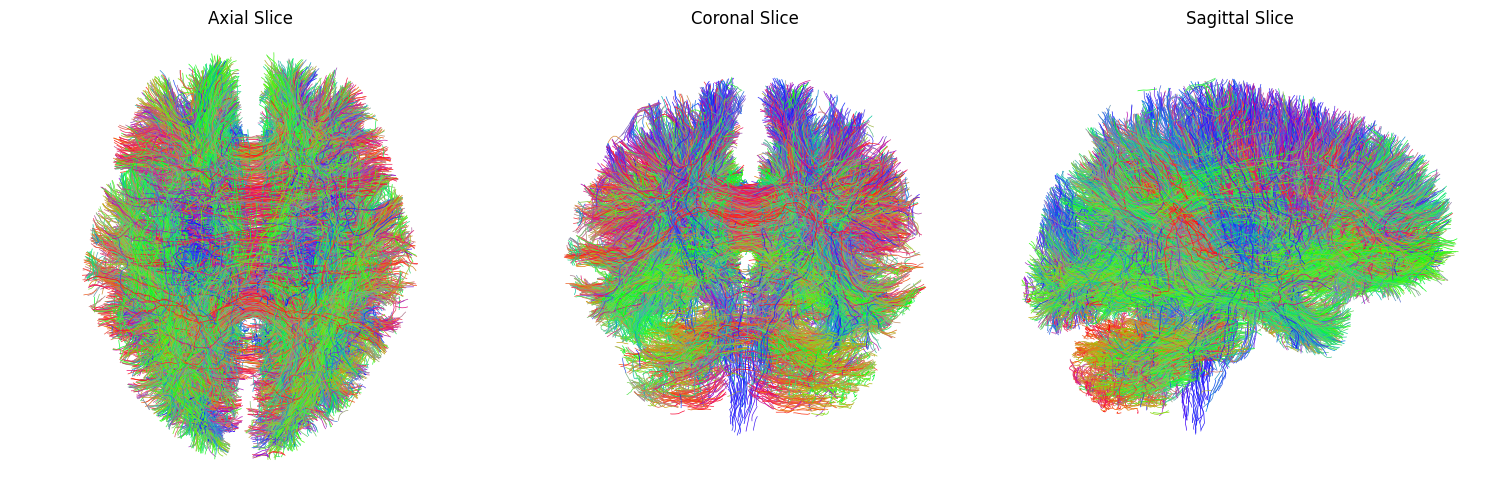

In [21]:
# Load the .tck file using nibabel
tractogram = nib.streamlines.load("./MRtrix_fod/smallerTracks_200k.tck")
streamlines = tractogram.streamlines
streamlines = list(streamlines)  

# Define the fraction of streamlines to display (e.g., 10%)
display_fraction = 0.1

# Randomly select a subset of streamlines
num_streamlines = len(streamlines)
subsampled_streamlines = random.sample(streamlines, int(display_fraction * num_streamlines))
streamlines_to_display = subsampled_streamlines # to visualize the whole sample use streamlines instead of subsampled_streamlines

# Use Fury's colormap for streamline coloring based on orientation
colors = colormap.line_colors(streamlines_to_display)

# Set up the plot with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Axial slice 
for streamline, color in zip(streamlines_to_display, colors):
    axes[0].plot(streamline[:, 0], streamline[:, 1], color=color, lw=0.5)
axes[0].axis("off")
axes[0].set_title("Axial Slice")
axes[0].axis("equal")

# Plot Coronal slice 
for streamline, color in zip(streamlines_to_display, colors):
    axes[1].plot(streamline[:, 0], streamline[:, 2], color=color, lw=0.5)
axes[1].axis("off")
axes[1].set_title("Coronal Slice")
axes[1].axis("equal")

# Plot Sagittal slice 
for streamline, color in zip(streamlines_to_display, colors):
    axes[2].plot(streamline[:, 1], streamline[:, 2], color=color, lw=0.5)
axes[2].axis("off")
axes[2].set_title("Sagittal Slice")
axes[2].axis("equal")

plt.tight_layout()
plt.show()

Remember to inspect this image to make sure that the streamlines end where you think they should; in other words, the streamlines should be constrained to the white matter, and they should be color-coded appropriately. For example, the corpus callosum should be mostly red, and the corona radiata should be mostly blue.

Although we have created a diffusion image with reasonable streamlines, also known as a tractogram, we still have a problem with some of the white matter tracts being over-fitted, and others being under-fitted. This can be addressed with the ```tcksift2``` command.

### Refining the Streamlines with tcksift2
You may ask why there is any need to modify the streamlines further once we have created our tractogram. The reason is that some tracts will be threaded with more streamlines than others, because the fiber orientation densities are much clearer and more attractive candidates for the probabilistic sampling algorithm that was discussed above. In other words, certain tracts can be over-represented by the amount of streamlines that pass through them not necessarily because they contain more fibers, but because the fibers tend to all be orientated in the same direction.

To counter-balance this overfitting, the command ```tcksift2``` will create a text file containing weights for each voxel in the brain:

In [22]:
! tcksift2 -act ./MRtrix_fod/5tt_coreg.mif -out_mu ./MRtrix_fod/sift_mu.txt -out_coeffs ./MRtrix_fod/sift_coeffs.txt -nthreads 20 ./MRtrix_fod/tracks_1M.tck ./MRtrix_fod/wmfod_norm.mif ./MRtrix_fod/sift_1M.txt

tcksift2: [100%] resampling ACT 5TT image to fixel image space[0K
tcksift2: [100%] segmenting FODs[0K
tcksift2: [100%] mapping tracks to image[0K
tcksift2:   Iteration     CF (data)      CF (reg)     Streamlines
tcksift2: [done]        45        18.723%         5.076%        9998211........................................................................................


####
The output from the command, “sift_1M.txt”, can be used with the command `tck2connectome` to create a matrix of how much each ROI is connected with every other ROI in the brain - a figure known as a connectome - which will weight each ROI. To see how to do that,  read the chapter on [Creating and Viewing the Connectome](https://andysbrainbook.readthedocs.io/en/latest/MRtrix/MRtrix_Course/MRtrix_08_Connectome.html#mrtrix-tutorial-8-creating-and-viewing-the-connectome) of Andy's Brain Book.